In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
from datetime import datetime
from scipy.signal import find_peaks
from scipy.optimize import curve_fit
from scipy.optimize import fsolve
from scipy.signal import savgol_filter
from scipy.interpolate import interp1d
from scipy.signal import find_peaks

In [2]:
Directory = '20220210'
Date = '2022-02-10'

In [3]:
File = '/gpfs/loomis/project/fas/david_moore/aj487/Data_WL110/Outgassing_Setup/{}/RGAScan_{}.h5'.format(Directory, Date)
rga_scans = np.array(pd.read_hdf(File, key='rga/rga'))
rga_timestamps = np.array(pd.read_hdf(File, key='rga/timestamp'))
amu = np.arange(1,100.01,0.1)
delta_t = np.array([datetime.strptime(x, '%Y%m%d%H%M%S') for x in rga_timestamps])

In [4]:
TempFile = '/gpfs/loomis/project/fas/david_moore/aj487/Data_WL110/Outgassing_Setup/{}/Temps_{}.h5'.format(Directory, Date)
temp = np.array(pd.read_hdf(TempFile, key='omega/omega'))
temp_timestamps = np.array(pd.read_hdf(TempFile, key='omega/timestamp'))
tempdelta_t = np.array([datetime.strptime(x, '%Y%m%d%H%M%S') for x in temp_timestamps])

In [5]:
PressFile = '/gpfs/loomis/project/fas/david_moore/aj487/Data_WL110/Outgassing_Setup/{}/Pressure_{}.h5'.format(Directory, Date)
press = np.array(pd.read_hdf(PressFile, key='ed/ed'))
press_timestamps = np.array(pd.read_hdf(PressFile, key='ed/timestamp'))
pressdelta_t = np.array([datetime.strptime(x, '%Y%m%d%H%M%S') for x in press_timestamps])
# pressdelta_t = np.array([(x-pressdelta_t[0]).total_seconds() for x in pressdelta_t])

In [6]:
TECFile = glob.glob('/gpfs/loomis/project/fas/david_moore/aj487/Data_WL110/Outgassing_Setup/{}/TEC_*.h5'.format(Directory))
TECFile.sort()
tec = np.empty(4, dtype='object')
tec_timestamps = np.empty(4, dtype='object')
for i, file in enumerate(TECFile):
    tec[i] =  np.array(pd.read_hdf(file, key='tec/tec'))
    tec_timestamps[i] = np.array(pd.read_hdf(file, key='tec/timestamp'))
tec = np.vstack(tec)
tec_timestamps = np.concatenate((tec_timestamps[0], tec_timestamps[1], tec_timestamps[2], tec_timestamps[3]))
tecdelta_t = np.array([datetime.strptime(x, '%Y%m%d%H%M%S') for x in tec_timestamps])
# tecdelta_t = np.array([(x-tecdelta_t[0]).total_seconds() for x in tecdelta_t])

In [7]:
# picking the temperature and time from the thermocouples that best matches each time the rga scan was made
rga_temp_ind = np.zeros(len(rga_scans), dtype='int64')
for i, t in enumerate(delta_t):
    if (len(np.where(tempdelta_t == t)[0]) > 0):
        rga_temp_ind[i] = np.where(tempdelta_t == t)[0][0]
    else:
        rga_temp_ind[i] = np.argmin(abs(tempdelta_t - t))
temp = temp[rga_temp_ind]
temp1 = temp[:,0]
temp2 = temp[:,1]
meantemp = np.mean(np.array([temp[:,0], temp[:,1]]), 0)
tempdelta_t = tempdelta_t[rga_temp_ind]

In [8]:
# resetting the start time to be the time of the first rga scan
time0 = delta_t[0]
delta_t = np.array([(x-time0).total_seconds() for x in delta_t])
tempdelta_t = np.array([(x-time0).total_seconds() for x in tempdelta_t])
tecdelta_t = np.array([(x-time0).total_seconds() for x in tecdelta_t])

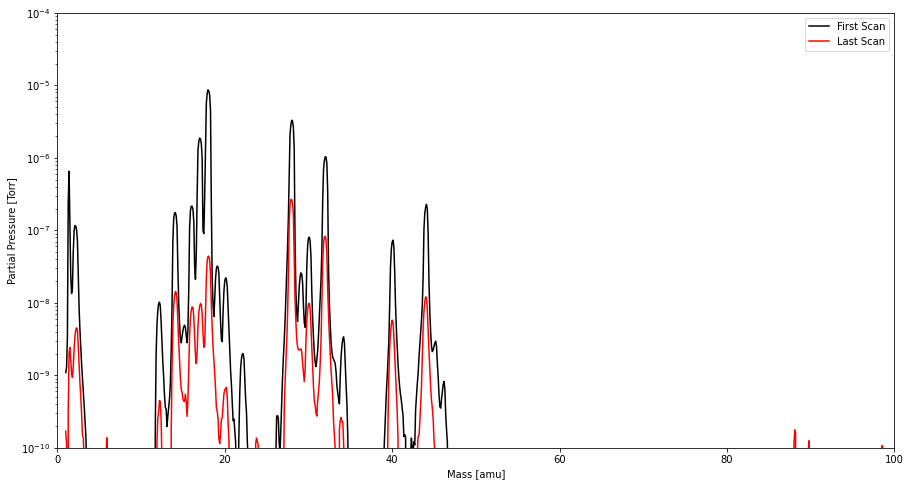

In [9]:
plt.figure(figsize=(15,8))
plt.xlabel('Mass [amu]')
plt.ylabel('Partial Pressure [Torr]')
plt.xlim(0,100)
plt.ylim(1e-10,1e-4)
total_p = []
for x in rga_scans: 
    total_p.append(np.sum(x))
    # plt.plot(amu, x, color='k', lw=1)
plt.plot(amu, rga_scans[0], color='k', alpha=1, label='First Scan')
plt.plot(amu, rga_scans[-1], color='r', alpha=1, label='Last Scan')
plt.legend(loc='upper right')

plt.yscale('log')
plt.show()

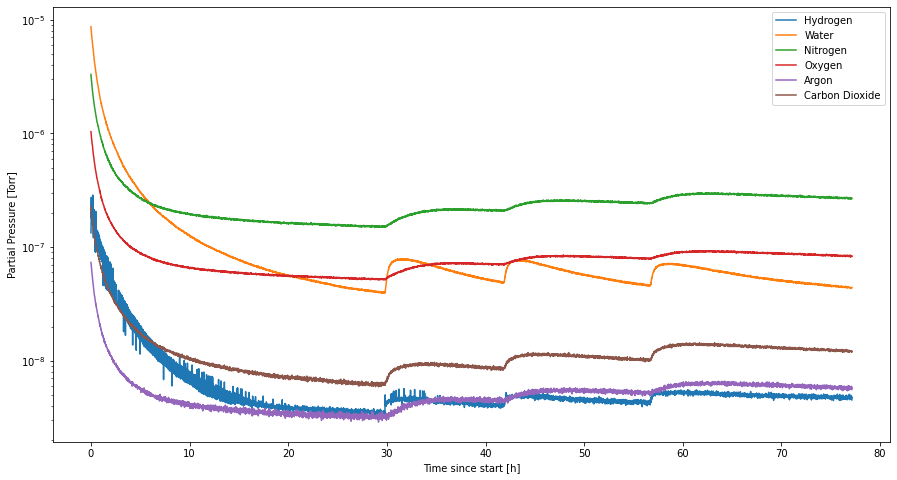

In [10]:
gases = [2,18,28,32,40,44]
labels = ['Hydrogen','Water','Nitrogen','Oxygen','Argon','Carbon Dioxide']

plt.figure(figsize=(15,8))
# plt.xlim(0,np.max(delta_t/3600.0))
# plt.ylim(1e-10,1e-4)
plt.xlabel('Time since start [h]')
plt.ylabel('Partial Pressure [Torr]')

for i,gas in enumerate(gases):
    cut = np.where((amu<gas+0.5) & (amu>gas-0.5))
    pp = [np.max(x[cut]) for x in rga_scans]
    plt.plot(delta_t/3600.0, pp, label=labels[i])

plt.legend(loc='upper right')
plt.yscale('log')
plt.show()

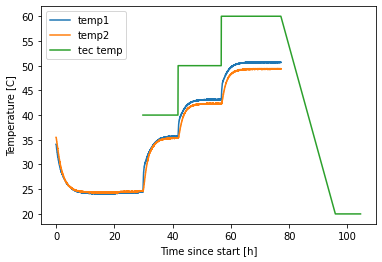

In [11]:
plt.figure()
# plt.plot(tempdelta_t, temp1-temp2)
plt.plot(tempdelta_t/3600, temp1, label='temp1')
plt.plot(tempdelta_t/3600, temp2, label='temp2')
plt.plot(tecdelta_t/3600, tec, label='tec temp')
plt.xlabel('Time since start [h]')
plt.ylabel('Temperature [C]')
plt.legend()
plt.show()

Fitting the diffusion equation to the oxygen partial pressures

In [12]:
def pick_gas(masses, elements):
    '''Returning a dictionary that includes the partial pressures from a certain gas'''
    rga_indiv_gas = {}
    for mass, element in zip(masses, elements):
        mask = np.where((amu<mass+0.5) & (amu>mass-0.5))
        rga_indiv_gas[element] = [np.max(rga[mask]) for rga in rga_scans]
    return rga_indiv_gas

In [13]:
o2pp = pick_gas([32], ['Oxygen'])['Oxygen']

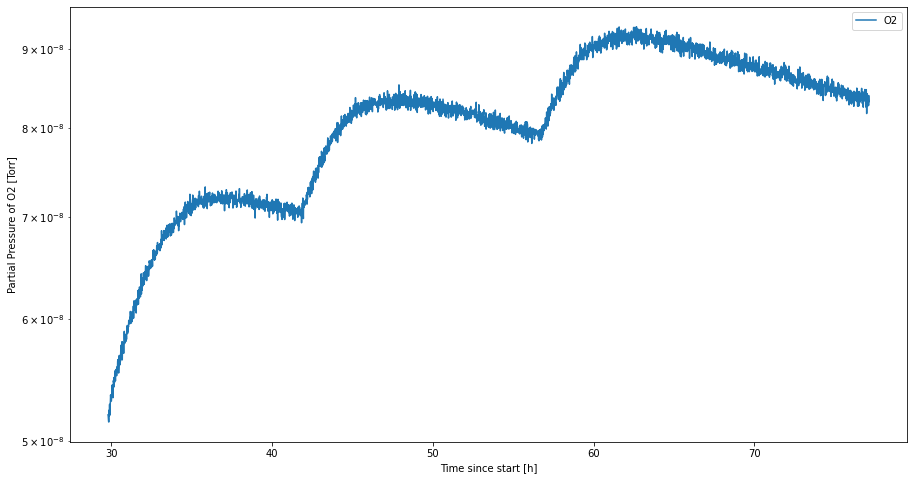

In [14]:
plt.figure(figsize=(15,8))
plt.plot(delta_t[2376:]/3600.0, o2pp[2376:], label='O2')
plt.yscale('log')
plt.xlabel('Time since start [h]')
plt.ylabel('Partial Pressure of O2 [Torr]')
plt.legend()
plt.show()

## Fitting all three peaks at once

Using function: $c_0 \sqrt{\frac{D}{t}}$

where $D = D_0 e^{-\frac{E_a}{k_BT}}$

Accounting for the delay in temperature change: convolving the mean temperature with $e^{-s\tau}$

In [103]:
def Laplace(time, temp, tau):
    x = time[:500]
    laplace = np.exp(-x/(tau*3600))/np.sum(np.exp(-x/(tau*3600)))
    T = np.convolve(temp, laplace, mode='full')
    # ignoring the first and last few elements to avoid boundary effects
    T[:500] = temp[:500]
#     T[-500:] = temp[-500:]
    return T[:-499]

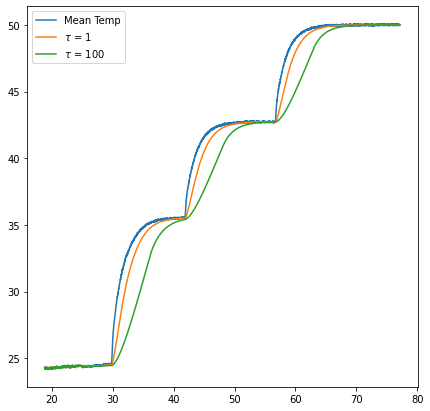

In [105]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(7,7))

axes.plot(tempdelta_t[1500:]/3600, meantemp[1500:], label='Mean Temp')

for tau in [1, 100]:
    T = Laplace(delta_t[1500:], meantemp[1500:], tau)
#     T[:500] = temp[:500]
#     T[-500:] = temp[-500:]
    axes.plot(tempdelta_t[1500:]/3600, T, label=r'$\tau$ = {}'.format(tau))
#     axes.plot(tempdelta_t/3600, T[499:], label=r'$\tau$ = {}'.format(tau))

plt.legend()

In [106]:
def fitfunction(tT,A,b,tau):
    '''Performing the fit function with the Laplace transform on the temperature data
    tT is a list with element 0 denoting time and element 1 denoting temperature'''
    T = Laplace(tT[0], tT[1], tau)
    D = np.exp(-1.0*b/T)
    return A * np.sqrt(D/tT[0]) # A = c_0 * sqrt(D_0)

def fit_outgassing_data(toffset, time, pp, mean_t, fit_params, sigma, index=None):
    '''Making an interpolation of the raw data, and fitting both the data 
    and interpolation to the fit function for the mean t'''
    if index is not None:
        time = time[index:]
        pp = pp[index:]
        mean_t = mean_t[index:]
    
    time = time-toffset
    
    #interpolation to smooth out the noise
    tt = np.linspace(time.min(), time.max(), len(time))
    itp = interp1d(time, pp, kind='linear')
    window_size, poly_order = 201, 3
    pp_sg = savgol_filter(itp(tt), window_size, poly_order)
    
    fits = {}
    chis = {}
    params = {}

    # fitting the raw data
    popt, pcov = curve_fit(fitfunction, [time, mean_t], pp, p0=fit_params, sigma=np.full(len(mean_t), sigma))
    fit = fitfunction([time, mean_t], *popt)
    chi_squared = np.sum((fit-pp)**2 / sigma)
    fits['Mean Temp'] = fit
    chis['Mean Temp'] = chi_squared
    params['Mean Temp'] = [popt[0], popt[1], popt[2]]

    # fitting the interpolation data
    popt_itp, pcov_itp = curve_fit(fitfunction, [tt, mean_t], pp_sg, p0=fit_params, sigma=np.full(len(mean_t), sigma))
    fit_itp = fitfunction([tt, mean_t], *popt_itp)
    chi_squared_itp = np.sum((fit_itp-pp_sg)**2 / sigma)
    fits['Mean Temp Interpolation'] = fit_itp
    chis['Mean Temp Interpolation'] = chi_squared_itp
    params['Mean Temp Interpolation'] = [popt_itp[0], popt_itp[1], popt_itp[2]]
        
    return [time, pp], [tt, pp_sg], fits, chis, params

In [96]:
delta_t[1500:]/3600

array([18.80138889, 18.81388889, 18.82666667, ..., 77.115     ,
       77.1275    , 77.14      ])

In [128]:
data1, interpol1, fits1, chis1, params1 = fit_outgassing_data(0, delta_t, o2pp, meantemp, [1, 1, 1], 
                                                         2e-8, index=1500)
data2, interpol2, fits2, chis2, params2 = fit_outgassing_data(0, delta_t, o2pp, meantemp, [1e-5, 1e5, 1000], 
                                                         2e-8, index=1500)
data3, interpol3, fits3, chis3, params3 = fit_outgassing_data(0, delta_t, o2pp, meantemp, [1, 1, 100], 
                                                         2e-8, index=1500)
data4, interpol4, fits4, chis4, params4 = fit_outgassing_data(0, delta_t, o2pp, meantemp, [1e5, 1e-5, 1], 
                                                         2e-8, index=1500)

/gpfs/loomis/project/david_moore/sw979/conda_envs/ycrc_default/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


In [129]:
data_list = [data1, data2, data3, data4]
interpol_list = [interpol1, interpol2, interpol3, interpol4]
fits_list = [fits1, fits2, fits3, fits4]
chis_list = [chis1, chis2, chis3, chis4]
params_list = [params1, params2, params3, params4]

count = 0
for data, interpol, fits, chis, params in zip(data_list, interpol_list, fits_list, chis_list, params_list):
    count += 1
    print(count)
    for par in params.keys():
        print('{} fit parameters: A = {:.3E}, b = {:.3E}, \n tau = {} \n Chi-squared: {:.3E}'.format(par, params[par][0], params[par][1],
                                                                                   params[par][2], chis[par]))

1
Mean Temp fit parameters: A = 1.130E-04, b = 9.493E+01, 
 tau = -75429849.60940647 
 Chi-squared: 2.967E-06
Mean Temp Interpolation fit parameters: A = 1.130E-04, b = 9.495E+01, 
 tau = -46193551.496193014 
 Chi-squared: 2.893E-06
2
Mean Temp fit parameters: A = 1.000E-05, b = 1.000E+05, 
 tau = 1000.0 
 Chi-squared: 1.371E-03
Mean Temp Interpolation fit parameters: A = 1.000E-05, b = 1.000E+05, 
 tau = 1000.0 
 Chi-squared: 1.371E-03
3
Mean Temp fit parameters: A = 1.151E-04, b = 9.815E+01, 
 tau = 1.9553783087317416 
 Chi-squared: 1.782E-06
Mean Temp Interpolation fit parameters: A = 1.130E-04, b = 9.495E+01, 
 tau = -397147023.7902919 
 Chi-squared: 2.893E-06
4
Mean Temp fit parameters: A = 1.130E-04, b = 9.493E+01, 
 tau = -5051862949.461411 
 Chi-squared: 2.967E-06
Mean Temp Interpolation fit parameters: A = 1.130E-04, b = 9.495E+01, 
 tau = -317259141.262568 
 Chi-squared: 2.893E-06


1
Mean Temp fit parameters: A = 1.130E-04, b = 9.493E+01, 
 tau = -75429849.60940647 
 Chi-squared: 2.967E-06
Mean Temp Interpolation fit parameters: A = 1.130E-04, b = 9.495E+01, 
 tau = -46193551.496193014 
 Chi-squared: 2.893E-06
2
Mean Temp fit parameters: A = 1.000E-05, b = 1.000E+05, 
 tau = 1000.0 
 Chi-squared: 1.371E-03
Mean Temp Interpolation fit parameters: A = 1.000E-05, b = 1.000E+05, 
 tau = 1000.0 
 Chi-squared: 1.371E-03
3
Mean Temp fit parameters: A = 1.151E-04, b = 9.815E+01, 
 tau = 1.9553783087317416 
 Chi-squared: 1.782E-06
Mean Temp Interpolation fit parameters: A = 1.130E-04, b = 9.495E+01, 
 tau = -397147023.7902919 
 Chi-squared: 2.893E-06
4
Mean Temp fit parameters: A = 1.130E-04, b = 9.493E+01, 
 tau = -5051862949.461411 
 Chi-squared: 2.967E-06
Mean Temp Interpolation fit parameters: A = 1.130E-04, b = 9.495E+01, 
 tau = -317259141.262568 
 Chi-squared: 2.893E-06


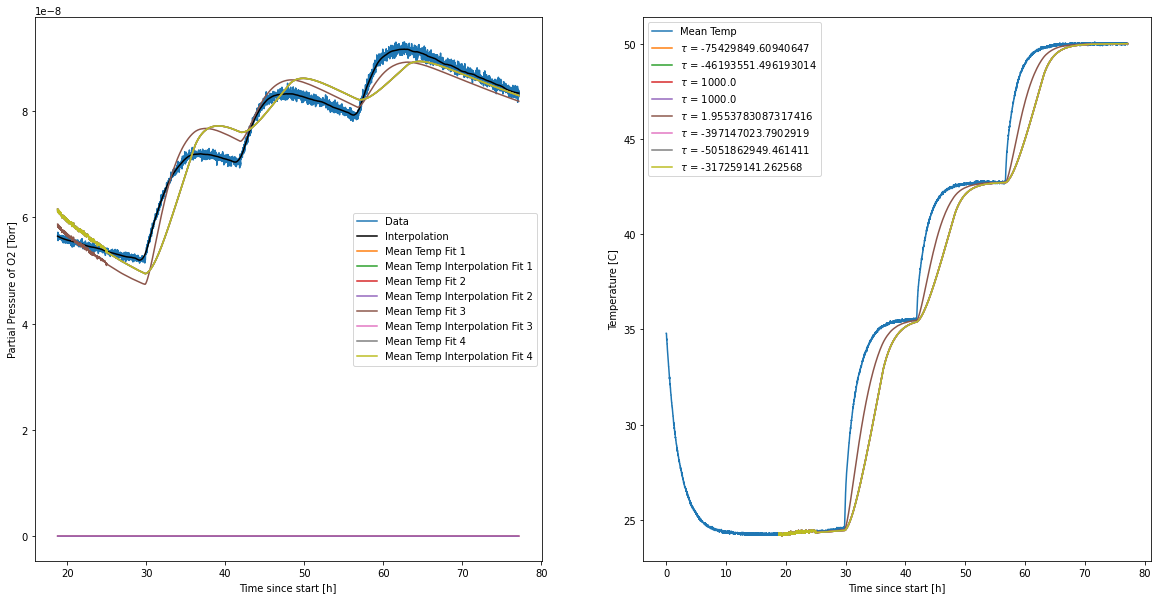

In [130]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,10))

# plotting data and interpolation
axes[0].plot(data1[0]/3600, data1[1], label='Data')
axes[0].plot(interpol1[0]/3600, interpol1[1], label='Interpolation', c='k')
axes[0].set_xlabel('Time since start [h]')
axes[0].set_ylabel('Partial Pressure of O2 [Torr]')

# plotting temperature data
axes[1].plot(tempdelta_t/3600, meantemp, label='Mean Temp')
axes[1].set_xlabel('Time since start [h]')
axes[1].set_ylabel('Temperature [C]')

count = 0
for data, interpol, fits, chis, params in zip(data_list, interpol_list, fits_list, chis_list, params_list):
    count += 1
    print(count)
    # plotting all the fits
    for j in fits.keys():
        if 'Interpolation' in j:
            axes[0].plot(interpol[0]/3600, fits[j], label='{} Fit {}'.format(j, count))
        else:
            axes[0].plot(data[0]/3600, fits[j], label='{} Fit {}'.format(j, count))
            
        # testing laplace transform on temp
        tau = params[j][2]
        T = Laplace(data[0], meantemp[1500:], tau)
        T_og = Laplace(delta_t[1500:], meantemp[1500:], tau)
#         x = data[0][:500]
#         
#         laplace = np.exp(-x/(tau*3600))/np.sum(np.exp(-x/(tau*3600))) # making the laplace function to smooth out T
#         T = np.convolve(data[1], laplace, mode='same')
#         T[:500] = data[1][:500] # ignoring the first and last few elements to avoid boundary effects
#         T[-500:] = data[1][-500:]
        
        axes[1].plot(data[0]/3600, T, label=r'$\tau$ = {}'.format(tau))
        
    axes[0].legend()
    axes[1].legend()

    for par in params.keys():
        print('{} fit parameters: A = {:.3E}, b = {:.3E}, \n tau = {} \n Chi-squared: {:.3E}'.format(par, params[par][0], params[par][1],
                                                                                   params[par][2], chis[par]))
plt.show()

## Fitting each peak individually

In [119]:
def find_smol_peaks(tec_data, tec_time, data, data_time):
    '''Separating data into the individual peaks based off of the time the tec temp changes'''
    data_with_peaks = {}
    diff = tec_data.flatten()[:-1]-tec_data.flatten()[1:]
    index = np.where(diff != 0)[0]+1
    index = np.insert(index, 0, 0)
    peak_timestamps = tec_time[index]
    peak_times = np.zeros(len(index), dtype='int')
    for i, t in enumerate(peak_timestamps):
        peak_times[i] = np.argmin(abs(t-data_time))
    for i, t in enumerate(peak_times):
        if i == 0:
            data_with_peaks['Peak {}'.format(i)] = data[:peak_times[i]]
#         elif i == len(index)-1:
#             data_with_peaks['Peak {}'.format(i)] = data[peak_times[i]:]
#             print(len(data[peak_times[i]:]))
        else:
            data_with_peaks['Peak {}'.format(i)] = data[peak_times[i-1]:peak_times[i]]
    return peak_times, data_with_peaks

In [120]:
peak_index, rga_scan_peaks = find_smol_peaks(tec, tecdelta_t, o2pp, delta_t)
peak_index, temp1_peaks = find_smol_peaks(tec, tecdelta_t, temp1, delta_t)
peak_index, temp2_peaks = find_smol_peaks(tec, tecdelta_t, temp2, delta_t)
peak_index, meantemp_peaks = find_smol_peaks(tec, tecdelta_t, meantemp, delta_t)
peak_index, time_peaks = find_smol_peaks(tec, tecdelta_t, delta_t, delta_t)

In [121]:
peak_index

array([2376, 3339, 4523, 6157])

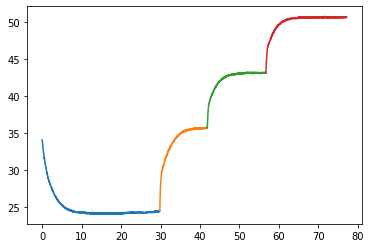

In [122]:
plt.figure()
plt.plot(time_peaks['Peak 0']/3600, temp1_peaks['Peak 0'])
plt.plot(time_peaks['Peak 1']/3600, temp1_peaks['Peak 1'])
plt.plot(time_peaks['Peak 2']/3600, temp1_peaks['Peak 2'])
plt.plot(time_peaks['Peak 3']/3600, temp1_peaks['Peak 3'])
plt.show()

Peak 1


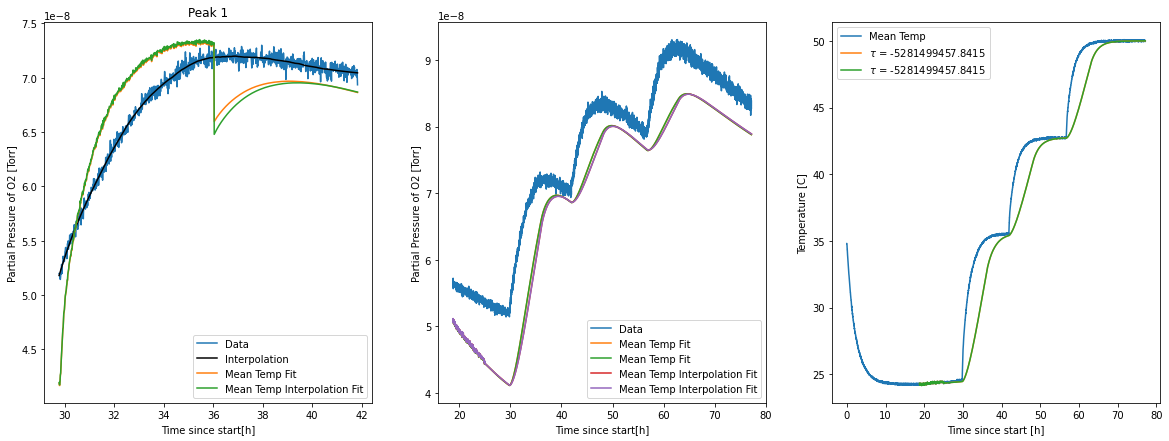

Mean Temp fit parameters: c = 1.219E-04, D0 = 1.077E+02, b = 1.050E+01 
 Chi-squared: 3.060E-06
Mean Temp Interpolation fit parameters: c = 1.221E-04, D0 = 1.077E+02, b = 5.697E+07 
 Chi-squared: 3.459E-06



Peak 2


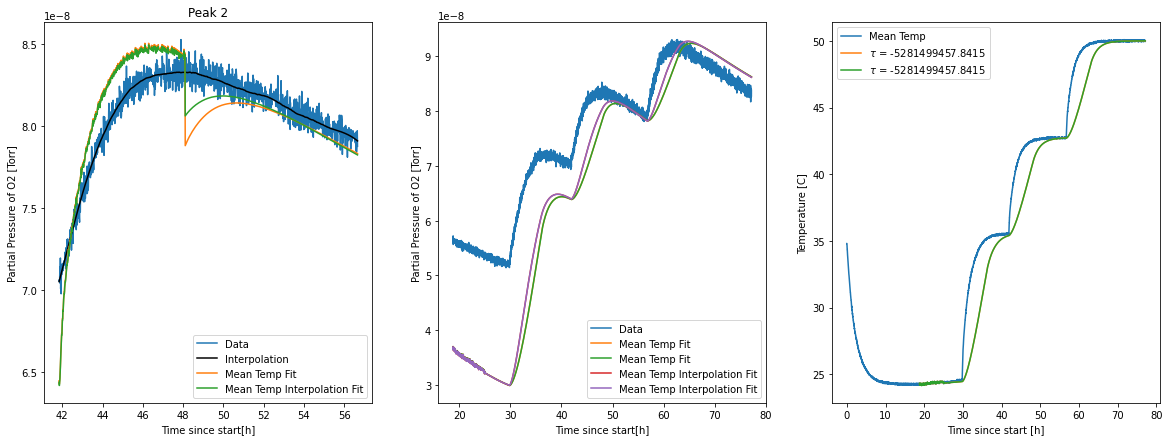

Mean Temp fit parameters: c = 1.973E-04, D0 = 1.468E+02, b = -1.308E+09 
 Chi-squared: 1.291E-06
Mean Temp Interpolation fit parameters: c = 1.973E-04, D0 = 1.469E+02, b = 4.537E+00 
 Chi-squared: 8.669E-07



Peak 3


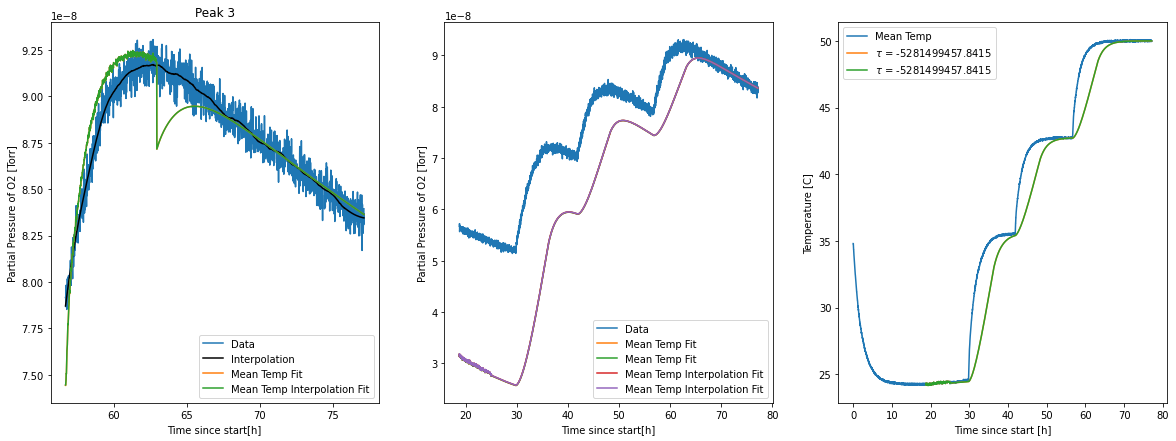

Mean Temp fit parameters: c = 2.146E-04, D0 = 1.583E+02, b = 6.120E+07 
 Chi-squared: 9.945E-07
Mean Temp Interpolation fit parameters: c = 2.142E-04, D0 = 1.581E+02, b = 9.695E+07 
 Chi-squared: 8.137E-07





In [127]:
for peak in time_peaks:
    if peak == 'Peak 0':
        continue

    print(peak)
    
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20,7))
    data_peaks, interpol_peaks, fits_peaks, chis_peaks, params_peaks = fit_outgassing_data(0, time_peaks[peak], 
                                                                                           rga_scan_peaks[peak], meantemp_peaks[peak], 
                                                                                           [11e5, 1e-5, 1], 3e-9)
#     print(params_peaks['T2'])
    # plotting data and interpolation
    for ax in axes[:-1]:
        ax.set_xlabel('Time since start[h]')
        ax.set_ylabel('Partial Pressure of O2 [Torr]')
    
    axes[0].plot(data_peaks[0]/3600, data_peaks[1], label='Data')
    axes[0].plot(interpol_peaks[0]/3600, interpol_peaks[1], label='Interpolation', c='k')
    axes[0].set_title(peak)
    
    axes[1].plot(data[0]/3600, data[1], label='Data')
    
    axes[2].plot(tempdelta_t/3600, meantemp, label='Mean Temp')
    axes[2].set_xlabel('Time since start [h]')
    axes[2].set_ylabel('Temperature [C]')

    
    # plotting all the fits
    for i in fits_peaks.keys():
        if 'Interpolation' in i:
            axes[0].plot(interpol_peaks[0]/3600, fits_peaks[i], label='{} Fit'.format(i))
        else:
            axes[0].plot(data_peaks[0]/3600, fits_peaks[i], label='{} Fit'.format(i))
    
        axes[1].plot(interpol[0]/3600, fitfunction([interpol[0], meantemp[1500:]], *params_peaks[i]), 
                     label='{} Fit'.format(i))
        axes[1].plot(data[0]/3600, fitfunction([data[0], meantemp[1500:]], *params_peaks[i]), 
                     label='{} Fit'.format(i))
        axes[2].plot(data[0]/3600, T, label=r'$\tau$ = {}'.format(tau))
            
    for ax in axes:
        ax.legend()
    plt.show()
    
    for par in params_peaks.keys():
        print('{} fit parameters: c = {:.3E}, D0 = {:.3E}, b = {:.3E} \n Chi-squared: {:.3E}'.format(par, params_peaks[par][0], 
                                                                                                    params_peaks[par][1], 
                                                                                                    params_peaks[par][2],
                                                                                                    chis_peaks[par]))
    print('\n\n')

<ipython-input-15-c5dc0deb7637>:3: RuntimeWarning: invalid value encountered in sqrt
  return c * np.sqrt(D/tT[0])


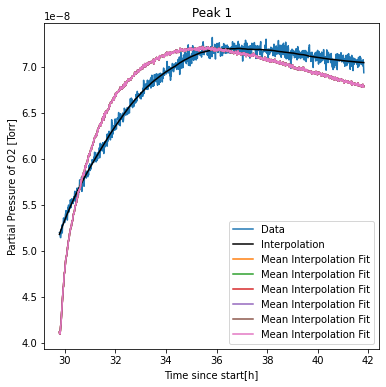

T1 fit parameters: a = 3.759E-06, b = 1.872E+03, c = 1.296E+02 
 Chi-squared: 1.441E-06
T1 Interpolation fit parameters: a = 3.320E-06, b = 2.396E+03, c = 1.295E+02 
 Chi-squared: 1.400E-06
T2 fit parameters: a = 2.736E-06, b = 1.163E+03, c = 8.986E+01 
 Chi-squared: 2.082E-06
T2 Interpolation fit parameters: a = 3.311E-06, b = 7.938E+02, c = 8.986E+01 
 Chi-squared: 2.022E-06
Mean fit parameters: a = 3.400E-06, b = 1.246E+03, c = 1.078E+02 
 Chi-squared: 1.619E-06
Mean Interpolation fit parameters: a = 3.034E-06, b = 1.563E+03, c = 1.078E+02 
 Chi-squared: 1.568E-06


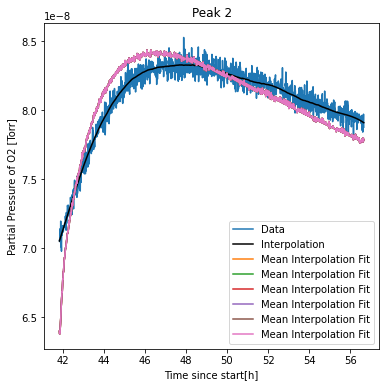

T1 fit parameters: a = 4.781E-06, b = 2.993E+03, c = 1.731E+02 
 Chi-squared: 7.492E-07
T1 Interpolation fit parameters: a = 5.736E-06, b = 2.083E+03, c = 1.732E+02 
 Chi-squared: 6.457E-07
T2 fit parameters: a = 3.702E-06, b = 1.708E+03, c = 1.247E+02 
 Chi-squared: 7.890E-07
T2 Interpolation fit parameters: a = 3.651E-06, b = 1.758E+03, c = 1.247E+02 
 Chi-squared: 6.843E-07
Mean fit parameters: a = 4.488E-06, b = 1.894E+03, c = 1.466E+02 
 Chi-squared: 7.053E-07
Mean Interpolation fit parameters: a = 4.227E-06, b = 2.138E+03, c = 1.467E+02 
 Chi-squared: 6.011E-07


<ipython-input-15-c5dc0deb7637>:3: RuntimeWarning: invalid value encountered in sqrt
  return c * np.sqrt(D/tT[0])


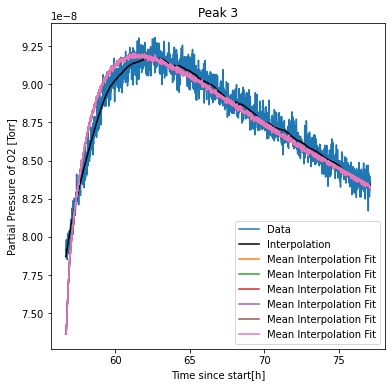

T1 fit parameters: a = 4.928E-06, b = 3.352E+03, c = 1.897E+02 
 Chi-squared: 5.458E-07
T1 Interpolation fit parameters: a = 5.783E-06, b = 2.434E+03, c = 1.897E+02 
 Chi-squared: 3.451E-07
T2 fit parameters: a = 4.479E-06, b = 1.587E+03, c = 1.384E+02 
 Chi-squared: 4.870E-07
T2 Interpolation fit parameters: a = 3.703E-06, b = 2.319E+03, c = 1.384E+02 
 Chi-squared: 2.931E-07
Mean fit parameters: a = 4.168E-06, b = 2.827E+03, c = 1.620E+02 
 Chi-squared: 4.589E-07
Mean Interpolation fit parameters: a = 4.295E-06, b = 2.661E+03, c = 1.619E+02 
 Chi-squared: 2.619E-07


In [27]:
for peak in time_peaks:
    if peak == 'Peak 0':
        continue
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6,6))
    data_peaks, interpol_peaks, fits_peaks, chis_peaks, params_peaks = fit_outgassing_data(0, time_peaks[peak], 
                                                                                           rga_scan_peaks[peak], temp1_peaks[peak], 
                                                                                           temp2_peaks[peak], meantemp_peaks[peak], 
                                                                                           [1.4e-7, 2.5e1, 2.1e-7], 3e-9)
    # plotting data and interpolation
    axes.plot(data_peaks[0]/3600, data_peaks[1], label='Data')
    axes.plot(interpol_peaks[0]/3600, interpol_peaks[1], label='Interpolation', c='k')
    axes.set_xlabel('Time since start[h]')
    axes.set_ylabel('Partial Pressure of O2 [Torr]')
    axes.set_title(peak)
    
    # plotting all the fits
    for i in fits_peaks.keys():
        if 'Interpolation' in j:
            axes.plot(interpol_peaks[0]/3600, fits_peaks[j], label='{} Fit'.format(j))
        else:
            axes.plot(data_peaks[0]/3600, fits_peaks[j], label='{} Fit'.format(j))
            
    plt.legend()
    plt.show()
    
    for par in params_peaks.keys():
        print('{} fit parameters: c = {:.3E}, D0 = {:.3E}, b = {:.3E} \n Chi-squared: {:.3E}'.format(par, params_peaks[par][0], 
                                                                                                    params_peaks[par][1], 
                                                                                                    params_peaks[par][2], 
                                                                                                    chis_peaks[par])) 
        

conductance 10L/s